In [2]:
## Libraries needed to run without MP-API
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from tabulate import tabulate
import json

plt.rcParams['animation.embed_limit'] = 2**128
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
})

In [3]:
with open("final_dict.json") as my_file:
    final_dict = json.load(my_file)
    for item in final_dict.items():
        print(f"{item[0]}: retrieved {len(item[1])} entries")

mp-ids: retrieved 157 entries
mp-ids-contrib: retrieved 157 entries
formula: retrieved 157 entries
metal: retrieved 157 entries
bulk_modulus: retrieved 157 entries
shear_modulus: retrieved 157 entries
therm_cond_300K_low_doping: retrieved 157 entries
elec_cond_300K_low_doping: retrieved 157 entries


In [4]:
## User-specified Parameters

# Desired 2-phase composite properties
# (targeting a AlSiC composite like that in airplane parts: k = 75 GPa, mu = 29 GPa, sigE = 35e6 S/m, K = 190 W/m/K)
k_effD = 75     # Desired effective bulk modulus, [Pa]
mu_effD = 29    # Desired effective shear modulus, [Pa]
sigE_effD =35e6 # Desired effective electrical conductivity,[S/m]
K_effD = 190    # Desired effective thermal conductivity, [W/m/K]

# Material 1 property search bounds
# (targeting silicon carbide: k = 213 GPa, mu = 187 GPa, sigE = 4.35e-4, K = 325 W/m/K)
k1min    = 100  # Lower bound for Phase 2 bulk modulus,     [GPa]
k1max    = 300  # Upper bound for Phase 2 bulk modulus,     [GPa]
mu1min   = 100  # Lower bound for Phase 2 shear modulus,    [GPa]
mu1max   = 300  # Upper bound for Phase 2 shear modulus,    [GPa]
K1min    = 100  # Lower bound for Phase 2 thermal cond.,    [W/m/K]
K1max    = 400  # Upper bound for Phase 2 thermal cond.,    [W/m/K]
sig1Emin = 1e4 # Lower bound for Phase 2 electrical cond., [S/m]
sig1Emax = 1e7 # Upper bound for Phase 2 electrical cond., [S/m]

# Material 2 property search bounds
# (targeting aluminum: k = 76 GPa, mu = 26 GPa, sigE = 37.7e6, K = 237 W/m/K)
k2min    = 50   # Lower bound for Phase 1 bulk modulus,     [GPa]
k2max    = 300   # Upper bound for Phase 1 bulk modulus,     [GPa]
mu2min   = 50   # Lower bound for Phase 1 shear modulus,    [GPa]
mu2max   = 300   # Upper bound for Phase 1 shear modulus,    [GPa]
K2min    = 100  # Lower bound for Phase 1 thermal cond.,    [W/m/K]
K2max    = 400  # Upper bound for Phase 1 thermal cond.,    [W/m/K]
sig2Emin = 1e4 # Lower bound for Phase 1 electrical cond., [S/m]
sig2Emax = 1e7 # Upper bound for Phase 1 electrical cond., [S/m]

In [5]:
## Program-specified Parameters

# Genetic algorithm parameters
P = 10   # number of design strings to breed
K = 10   # number of offspring design strings 
G = 5000 # maximum number of generations
S = 200  # total number of design strings per generation
dv = 10  # number of design variables per string

# Shared properties between materials 1 and 2
v1min = 0 # Lower bound for volume fraction,       []
v1max = 1 # Upper bound for volume fraction,       []
gmin  = 0 # Lower bound for HS averaging constant, []
gmax  = 1 # Upper bound for HS averaging constant, []

# Concentration factor tolerances
TOL_k = 0.5   # Bulk modulus tolerance,  []
TOL_mu = 0.5  # Shear modulus tolerance, []
TOL_K = 0.5   # Thermal tolerance,       []
TOL_sig = 0.8 # Electrical tolerance,    []

# Given Cost Function Weights
W1 = 1/3 # Electrical weight,            []
W2 = 1/3 # Thermal weight,               []
W3 = 1/3 # Mechanical weight,            []
w1 = 1   # Material property weights,    []
wj = 0.5 # Concentration tensor weights, []

# Assemble Search Bound Vectors
lower_bounds = np.array([k1min, mu1min, sig1Emin, K1min, k2min, mu2min, sig2Emin, K2min, v1min, gmin])
upper_bounds = np.array([k1max, mu1max, sig1Emax, K1max, k2max, mu2max, sig2Emax, K2max, v1max, gmax])

In [6]:
## Genetic Algorithm Helper Functions

def sort(pi):
    new_pi = np.sort(pi, axis=0)
    ind = np.argsort(pi, axis=0)
    return [new_pi, ind]

def reorder(Lambda, ind):
    temp = np.zeros((S,dv))
    for i in range(0, len(ind)):
        temp[i,:] = Lambda[int(ind[i]),:]
    Lambda = temp
    return Lambda

def get_unique_designs(Lambda, costs):

    # Costs are often equal to >10 decimal points
    # Truncate to obtain a richer set of suggestions
    new_costs = np.round(costs, decimals=3)
    
    # Obtain Unique Strings and Costs
    [unique_costs, iuniq] = np.unique(new_costs, return_index=True)
    unique_strings = Lambda[iuniq]

    return [unique_strings, unique_costs] 


In [7]:
## Cost Function Definition

# An anonymous function for evaluating fitness
def Pi(Lambda):

    # Extract design parameters from genetic string
    k1, mu1, sig1E, K1, k2, mu2, sig2E, K2, v1, gamma = [float(elem) for elem in Lambda]
    v2 = 1 - v1  

    ## Min and Max Effective Property Bounds
    # Bounds on electrical conductivity
    sigE_min = sig1E + v2 / (1/(sig2E - sig1E) + v1/(3*sig1E))
    sigE_max = sig2E + v1 / (1/(sig1E - sig2E) + v2/(3*sig2E))
    
    # Bounds on thermal conducitivity
    K_min = K1 + v2 / (1/(K2 - K1) + v1/(3*K1))
    K_max = K2 + v1 / (1/(K1 - K2) + v2/(3*K2))
    
    # Bounds on bulk modulus
    k_min = k1 + v2 / (1/(k2 -k1) + 3*v1/(3*k1 + 4*mu1))
    k_max = k2 + v1 / (1/(k1 -k2) + 3*v2/(3*k2 + 4*mu2))
    
    # Bounds on shear modulus
    mu_min = mu1 + v2 / (1/(mu2 - mu1) + 6*v1*(k1 + 2*mu1) / (5*mu1*(3*k1 + 4*mu1)))
    mu_max = mu2 + v1 / (1/(mu1 - mu2) + 6*v2*(k2 + 2*mu2) / (5*mu2*(3*k2 + 4*mu2)))
    
    ## Effective Material Properties
    sigE_eff = gamma * sigE_max + (1 - gamma) * sigE_min
    K_eff    = gamma * K_max    + (1 - gamma) * K_min
    k_eff    = gamma * k_max    + (1 - gamma) * k_min
    mu_eff   = gamma * mu_max   + (1 - gamma) * mu_min
    
    ## Concentration Tensor Determination
    # Electrical Load Sharing
    CJ1CE1 = sig1E/sigE_eff * (1/v1 * (sig2E - sigE_eff)/(sig2E - sig1E))**2
    CJ2CE2 = sig2E/sigE_eff * (1/v2 * (sig1E - sigE_eff)/(sig1E - sig2E))**2
    
    # Thermal Load Sharing
    Ct2 = 1/v2 * (K_eff - K1) / (K2 - K1) 
    Ct1 = 1/v1 * (1 - v2 * Ct2) 
    Cq2 = K2 * Ct2 * 1/K_eff
    Cq1 = 1/v1 * (1 - v2 * Cq2)
        
    # Mechanical Load Sharing
    Ck2  = 1/v2 * k2/k_eff   * (k_eff - k1) / (k2 - k1)
    Cmu2 = 1/v2 * mu2/mu_eff * (mu_eff - mu1)/(mu2 - mu1)
    Ck1  = 1/v1 * (1 - v2 * Ck2)
    Cmu1 = 1/v1 * (1 - v2 * Cmu2)
    
    ## Cost Function Weight Determination
    # Assign concentration tensor weights
    w2E = wj
    w3E = wj
    w2T = wj
    w3T = wj
    w3M = wj
    w4M = wj
    w5M = wj
    w6M = wj
    
    # Electrical weights
    if (CJ1CE1 - TOL_sig) / TOL_sig > 0:
        w2E_hat = w2E
    else:
        w2E_hat = 0

    if (CJ2CE2 - TOL_sig) / TOL_sig > 0:
        w3E_hat = w3E
    else:
        w3E_hat = 0
    
    # Thermal weights
    if (Cq1 - TOL_K) / TOL_K > 0:
        w2T_hat = w2T
    else:
        w2T_hat = 0

    if (Cq2 - TOL_K) / TOL_K > 0:
        w3T_hat = w3T
    else:
        w3T_hat = 0
    
    # Mechanical weights
    if (Ck2 - TOL_k) > 0:
        w3M_hat = w3M
    else:
        w3M_hat = 0

    if (Cmu2 - TOL_mu) > 0:
        w4M_hat = w4M
    else:
        w4M_hat = 0

    if (Ck1 - TOL_k) > 0:
        w5M_hat = w5M
    else:
        w5M_hat = 0

    if (Cmu1 - TOL_mu) > 0:
        w6M_hat = w6M
    else:
        w6M_hat = 0

    ## Cost Functions
    # Electrical Property Cost Function
    Pi_elec = w1      * abs((sigE_effD - sigE_eff) / sigE_effD) \
            + w2E_hat * abs((CJ1CE1   - TOL_sig)   / TOL_sig) \
            + w3E_hat * abs((CJ2CE2   - TOL_sig)   / TOL_sig)

    # Thermal Property Cost Function    
    Pi_thermo = w1      * abs((K_effD - K_eff) / K_effD) \
              + w2T_hat * abs((Cq1    - TOL_K) / TOL_K) \
              + w3T_hat * abs((Cq2    - TOL_K) / TOL_K)
        
    # Mechanical Property Cost Function
    Pi_mech = w1      * abs((k_effD  - k_eff) / k_effD) \
            + w1      * abs((mu_effD - mu_eff)/ mu_effD) \
            + w3M_hat * abs((Ck2     - TOL_k) / TOL_k) \
            + w4M_hat * abs((Cmu2    - TOL_mu)/ TOL_mu) \
            + w5M_hat * abs((Ck1     - TOL_k) / TOL_k) \
            + w6M_hat * abs((Cmu1    - TOL_mu)/ TOL_mu)

    # Multi-property (Combined) Cost Function
    cost = W1 * Pi_elec + W2 * Pi_thermo + W3 * Pi_mech

    return cost

In [8]:
## Material Property Optimization, CASE A 
# - Keep the top P=10 parents after each generation
# - Produce 10 offspring
# - Generate 180 new random strings

def caseA():
    
    # Initialize arrays to store the cost and original indices of each generation
    PI = np.ones((G, S))
    Orig = np.ones((G, S))
    
    # Initialize arrays to store best performer and parent avg 
    Pi_min = np.zeros(G)     # best cost
    Pi_par_avg = np.zeros(G) # avg cost of parents
    
    # Generation counter
    g = 0

    # Initialize array to store costs for current generation
    cost = np.zeros(S)

    # Randomly populate first generation  
    Lambda = np.ones((S, dv))
    for i in range (S):
        Lambda[i, :] = np.random.uniform(lower_bounds, upper_bounds)
        cost[i] = Pi(Lambda[i, :])
            
    # Sort the costs of the first generation
    [new_cost, ind] = sort(cost)  
    PI[g, :] = new_cost.reshape(1,S) 
    
    # Store the cost of the best performer and average cost of the parents 
    Pi_min[g] = np.min(new_cost)
    Pi_par_avg[g] = np.mean(new_cost[0:P])
    
    # Update Lambda based on sorted indices
    Lambda = reorder(Lambda, ind)
    Orig[g,:] = ind.reshape(1,S) 
    
    # Perform all later generations    
    while g < G:
        
        print(g)
        cost[0:P] = new_cost[0:P] # retain the parents from the previous generation
        
        # Select top parents P from Lambda to be breeders
        for p in range(0, P, 2):
            phi1, phi2 = np.random.rand(2)
            kid1 = phi1*Lambda[p, :] + (1-phi1)*Lambda[p+1, :]
            kid2 = phi2*Lambda[p, :] + (1-phi2)*Lambda[p+1, :]
            
            # Append offspring to Lambda 
            Lambda[P+p,   :] = kid1
            Lambda[P+p+1, :] = kid2
        
            # Evaluate Offspring
            cost[P+p]   = Pi(Lambda[P+p, :])
            cost[P+p+1] = Pi(Lambda[P+p+1, :])
                     
        # Randomly generate new design strings to fill th rest of the population
        for i in range(S-P-K):
            Lambda[P+K+i, :] = np.random.uniform(lower_bounds, upper_bounds)
            cost[P+K+i] = Pi(Lambda[P+K+i, :])

        # Sort the costs for the gth generation
        [new_cost, ind] = sort(cost)  
        PI[g, :] = new_cost.reshape(1,S) 
    
        # Store the cost of the best performer and average cost of the parents 
        Pi_min[g] = np.min(new_cost)
        Pi_par_avg[g] = np.mean(new_cost[0:P])
    
        # Update Lambda based on sorted indices
        Lambda = reorder(Lambda, ind)
        Orig[g,:] = ind.reshape(1,S)  

        # Update the generation counter
        g = g + 1          
    
    return PI, Lambda, Orig, Pi_min, Pi_par_avg   


In [9]:
# Call the Genetic Algorithm for Case A  
PI, Lambda, Orig, Pi_min, Pi_par_avg = caseA() # Keep the top P=10 parents after each generation
                                               # Produce 10 offspring
                                               # Generate 180 new random strings

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

MOLYBDENUM AND ALUMINUM MATERIAL PROPERTIES
  k    mu      sigE    K
---  ----  --------  ---
263   119  1.8e+07   128
 76    26  3.77e+07  237

HASHIN-SHTRIKMAN + GENETIC ALGORITHM RECOMMENDED MATERIAL PROPERTIES
     k1      mu1             sig1E       K1        k2       mu2        sig2E       K2         v1      gamma    Cost
-------  -------  ----------------  -------  --------  --------  -----------  -------  ---------  ---------  ------
119.809  144.159       2.89524e+06  143.513   74.1417   54.7659  8.36022e+06  194.756  0.0243114  0.833965    1.794
172.849  185.383       6.40082e+06  191.378   77.5904   87.0987  6.93174e+06  239.186  0.0380499  0.921326    2.366
230.032  158.688       3.04545e+06  305.849   86.2035   53.1081  9.84939e+06  215.093  0.423406   0.408737    2.395
112.212  129.288       9.2938e+06   115.387   56.3198   90.9608  9.33156e+06  183.706  0.649251   0.730247    2.44
197.891  146.744       2.47511e+06  174.508  185.015    78.0231  4.78811e+06  192.733  0.04

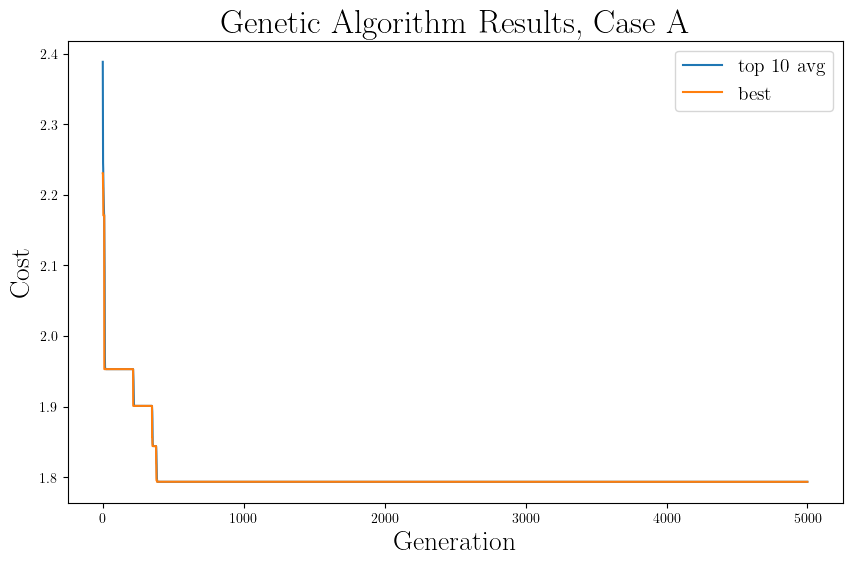

In [11]:
# Print Expected Results
# Molybdenum: k = 263 GPa, mu = 119 GPa, sigE = 18e6, K = 138 W/m/K
# Aluminum: k = 76 GPa, mu = 26 GPa, sigE = 37.7e6, K = 237 W/m/K
Mo = np.array([263, 119, 18e6, 128])
Al = np.array([76, 26, 37.7e6, 237])
headers = ['k', 'mu', 'sigE', 'K']
table_data = np.vstack((Mo, Al))
print('MOLYBDENUM AND ALUMINUM MATERIAL PROPERTIES')
print(tabulate(table_data, headers=headers))

# Reveal Best Designs
[unique_strings, unique_costs] = get_unique_designs(Lambda, PI[-1,:])
headers = ['k1', 'mu1', 'sig1E', 'K1', 'k2', 'mu2', 'sig2E', 'K2', 'v1', 'gamma', 'Cost']
table_data = np.hstack((unique_strings[0:20,:], unique_costs[0:20].reshape(-1,1)))
print('\nHASHIN-SHTRIKMAN + GENETIC ALGORITHM RECOMMENDED MATERIAL PROPERTIES')
print(tabulate(table_data, headers=headers))

# Plotting
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(G), Pi_par_avg, label='top 10 avg')
ax.plot(range(G), Pi_min, label="best ")
plt.xlabel('Generation', fontsize= 20)
plt.ylabel('Cost', fontsize=20)
plt.title('Genetic Algorithm Results, Case A', fontsize = 24)
plt.legend(fontsize = 14)
plt.show()

In [15]:
## (Material 1) Filter the dictionary extracted from MP-API based on GA results
mat_1_dict = {"mp-ids": [],
              "mp-ids-contrib": [], 
              "formula": [],
              "metal": [],
              "bulk_modulus": [],
              "shear_modulus": [],
              "therm_cond_300K_low_doping": [],
              "elec_cond_300K_low_doping": []}

bulk_mod_lower_bound = min(table_data[:,0])
bulk_mod_upper_bound = max(table_data[:,0])
shear_mod_lower_bound = min(table_data[:,1])
shear_mod_upper_bound = max(table_data[:,1])
elec_cond_lower_bound = min(table_data[:,2])
elec_cond_upper_bound = max(table_data[:,2])
therm_cond_lower_bound = min(table_data[:,3])
therm_cond_upper_bound = max(table_data[:,3])

# Get materials that satisfy the bulk modulus constraints for material 1
mat_1_bulk_idx = []
for i, bulk_mod in enumerate(final_dict["bulk_modulus"]):
    if (bulk_mod >= bulk_mod_lower_bound) and (bulk_mod <= bulk_mod_upper_bound):       
        mat_1_bulk_idx.append(i)
print(mat_1_bulk_idx)

# Get materials that satisfy the shear modulus constraints for material 1
mat_1_shear_idx = []
for i, shear_mod in enumerate(final_dict["shear_modulus"]):
    if (shear_mod >= shear_mod_lower_bound) and (shear_mod <= shear_mod_upper_bound): 
        mat_1_shear_idx.append(i) 
print(mat_1_shear_idx)

# Get materials that satisfy the room temp, low doping electrical conductivity constraints for material 1
mat_1_elec_idx = []
for i, elec_cond in enumerate(final_dict["elec_cond_300K_low_doping"]):
    if (elec_cond >= elec_cond_lower_bound) and (elec_cond <= elec_cond_upper_bound):  
        mat_1_elec_idx.append(i)
print(mat_1_elec_idx)

# Get materials that satisfy the room temp, low doping electrical conductivity constraints for material 1
mat_1_therm_idx = []      
for i, therm_cond in enumerate(final_dict["therm_cond_300K_low_doping"]):
    if (therm_cond >= therm_cond_lower_bound) and (therm_cond <= elec_cond_upper_bound):  
        mat_1_therm_idx.append(i)
print(mat_1_therm_idx)

mat_1_indices = list(set(mat_1_bulk_idx) & set(mat_1_shear_idx) & set(mat_1_elec_idx) & set(mat_1_therm_idx))
print(mat_1_indices)

# Options for material 1


[0, 1, 2, 3, 4, 11, 13, 19, 23, 24, 26, 27, 30, 32, 36, 38, 40, 41, 42, 43, 44, 45, 46, 49, 50, 52, 59, 63, 69, 71, 72, 75, 76, 77, 79, 80, 82, 83, 85, 86, 87, 88, 89, 92, 94, 96, 103, 105, 106, 107, 108, 109, 110, 111, 112, 115, 116, 117, 119, 120, 121, 124, 127, 131, 132, 134, 135, 136, 137, 138, 139, 141, 144, 145, 146, 147, 156]
[1, 11, 72, 82, 93, 108, 131, 156]
[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 54, 55, 56, 57, 58, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156]
[104]
[]


In [14]:
## (Material 2) Filter the dictionary extracted from MP-API based on GA results
mat_2_dict = {"mp-ids": [],
              "mp-ids-contrib": [], 
              "formula": [],
              "metal": [],
              "bulk_modulus": [],
              "shear_modulus": [],
              "therm_cond_300K_low_doping": [],
              "elec_cond_300K_low_doping": []}

bulk_mod_lower_bound = min(table_data[:,4])
bulk_mod_upper_bound = max(table_data[:,4])
shear_mod_lower_bound = min(table_data[:,5])
shear_mod_upper_bound = max(table_data[:,5])
elec_cond_lower_bound = min(table_data[:,6])
elec_cond_upper_bound = max(table_data[:,6])
therm_cond_lower_bound = min(table_data[:,7])
therm_cond_upper_bound = max(table_data[:,7])

# Get materials that satisfy the bulk modulus constraints for material 2
mat_2_bulk_idx = []
for i, bulk_mod in enumerate(final_dict["bulk_modulus"]):
    if (bulk_mod >= bulk_mod_lower_bound) and (bulk_mod <= bulk_mod_upper_bound):       
        mat_2_bulk_idx.append(i)
print(mat_2_bulk_idx)

# Get materials that satisfy the shear modulus constraints for material 2
mat_2_shear_idx = []
for i, shear_mod in enumerate(final_dict["shear_modulus"]):
    if (shear_mod >= shear_mod_lower_bound) and (shear_mod <= shear_mod_upper_bound): 
        mat_2_shear_idx.append(i) 
print(mat_2_shear_idx)

# Get materials that satisfy the room temp, low doping electrical conductivity constraints for material 2
mat_2_elec_idx = []
for i, elec_cond in enumerate(final_dict["elec_cond_300K_low_doping"]):
    if (elec_cond >= elec_cond_lower_bound) and (elec_cond <= elec_cond_upper_bound):  
        mat_2_elec_idx.append(i)
print(mat_2_elec_idx)

# Get materials that satisfy the room temp, low doping electrical conductivity constraints for material 2
mat_2_therm_idx = []      
for i, therm_cond in enumerate(final_dict["therm_cond_300K_low_doping"]):
    if (therm_cond >= therm_cond_lower_bound) and (therm_cond <= elec_cond_upper_bound):  
        mat_2_therm_idx.append(i)
print(mat_2_therm_idx)

mat_2_indices = list(set(mat_2_bulk_idx) & set(mat_2_shear_idx) & set(mat_2_elec_idx) & set(mat_2_therm_idx))
print(mat_2_indices)

[0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 58, 59, 60, 62, 63, 66, 67, 69, 70, 71, 72, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 92, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 150, 153, 154, 156]
[0, 2, 3, 11, 13, 19, 23, 24, 27, 29, 30, 32, 33, 36, 38, 40, 41, 42, 45, 46, 52, 62, 63, 69, 71, 72, 75, 76, 77, 79, 80, 82, 83, 85, 86, 88, 89, 92, 94, 95, 96, 100, 103, 105, 106, 108, 109, 110, 111, 112, 114, 115, 116, 117, 119, 121, 124, 127, 129, 131, 135, 136, 137, 139, 141, 143, 144, 145, 147, 156]
[2, 3, 6, 7, 8, 10, 11, 12, 17, 21, 23, 24, 27, 28, 31, 33, 34, 36, 37, 39, 40, 42, 43, 44, 46, 49, 50, 51, 54, 55, 56, 57, 64, 65, 66, 67, 68, 70

In [ ]:
## Material Property Optimization, CASE B
# - Do NOT keep top P=10 parents after each generation
# - Produce 10 offspring
# - Generate 190 new random strings

def caseB():
    
    # Initialize arrays to store the cost and original indices of each generation
    PI = np.ones((G, S))
    Orig = np.ones((G, S))
    
    # Initialize arrays to store best performer and parent avg 
    Pi_min = np.zeros(G)     # best cost
    Pi_par_avg = np.zeros(G) # avg cost of parents
    
    # Generation counter
    g = 0

    # Initialize array to store costs for current generation
    cost = np.zeros(S)

    # Randomly populate first generation  
    Lambda = np.ones((S, dv))
    for i in range (S):
        Lambda[i, :] = np.random.uniform(lower_bounds, upper_bounds)
        cost[i] = Pi(Lambda[i, :])
            
    # Sort the costs of the first generation
    [new_cost, ind] = sort(cost)  
    PI[g, :] = new_cost.reshape(1,S) 
    
    # Store the cost of the best performer and average cost of the parents 
    Pi_min[g] = np.min(new_cost)
    Pi_par_avg[g] = np.mean(new_cost[0:P])
    
    # Update Lambda based on sorted indices
    Lambda = reorder(Lambda, ind)
    Orig[g,:] = ind.reshape(1,S) 
    
    # Perform all later generations    
    while g < G:
        
        print(g)
        cost = np.zeros(S) # do NOTretain the parents from the previous generation
        
        # Select top parents P from Lambda to be breeders
        for p in range(0, P, 2):
            phi1, phi2 = np.random.rand(2)
            kid1 = phi1*Lambda[p, :] + (1-phi1)*Lambda[p+1, :]
            kid2 = phi2*Lambda[p, :] + (1-phi2)*Lambda[p+1, :]
            
            # Append offspring to Lambda 
            Lambda[p,   :] = kid1
            Lambda[p+1, :] = kid2
        
            # Evaluate Offspring
            cost[p]   = Pi(Lambda[p, :])
            cost[p+1] = Pi(Lambda[p+1, :])
                     
        # Randomly generate new design strings to fill th rest of the population
        for i in range(S-K):
            Lambda[K+i, :] = np.random.uniform(lower_bounds, upper_bounds)
            cost[K+i] = Pi(Lambda[K+i, :])

        # Sort the costs for the gth generation
        [new_cost, ind] = sort(cost)  
        PI[g, :] = new_cost.reshape(1,S) 
    
        # Store the cost of the best performer and average cost of the parents 
        Pi_min[g] = np.min(new_cost)
        Pi_par_avg[g] = np.mean(new_cost[0:P])
    
        # Update Lambda based on sorted indices
        Lambda = reorder(Lambda, ind)
        Orig[g,:] = ind.reshape(1,S)  

        # Update the generation counter
        g = g + 1          
    
    return PI, Lambda, Orig, Pi_min, Pi_par_avg   


In [ ]:
# Call the Genetic Algorithm for Case B  
PI, Lambda, Orig, Pi_min, Pi_par_avg = caseB() # Do NOT keep the top P=10 parents after each generation
                                               # Produce 10 offspring
                                               # Generate 190 new random strings

In [ ]:
# Print Expected Results
# Silicon Carbide: k = 213 GPa, mu = 187 GPa, sigE = 4.35e-4, K = 325 W/m/K
# Aluminum: k = 76 GPa, mu = 26 GPa, sigE = 37.7e6, K = 237 W/m/K
# Typical volume fractions are 3-18% SiC in Al
SiC = np.array([213, 187, 4.35e-4, 325])
Al = np.array([76, 26, 37.7e6, 237])
headers = ['k', 'mu', 'sigE', 'K']
table_data = np.vstack((SiC, Al))
print('SILICON CARBIDE AND ALUMINUM MATERIAL PROPERTIES')
print(tabulate(table_data, headers=headers))

# Reveal Best Designs
[unique_strings, unique_costs] = get_unique_designs(Lambda, PI[-1,:])
headers = ['k1', 'mu1', 'sig1E', 'K1', 'k2', 'mu2', 'sig2E', 'K2', 'v1', 'gamma', 'Cost']
table_data = np.hstack((unique_strings[0:20,:], unique_costs[0:20].reshape(-1,1)))
print(tabulate(table_data, headers=headers))

# Plotting
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(G), Pi_par_avg, label='top 10 avg')
ax.plot(range(G), Pi_min, label="best ")
plt.xlabel('Generation', fontsize= 20)
plt.ylabel('Cost', fontsize=20)
plt.title('Genetic Algorithm Results, Case B', fontsize = 24)
plt.legend(fontsize = 14)
plt.show()

In [ ]:
## Material Property Optimization, CASE C
# - Keep top P=10 parents after each generation
# - Produce 10 offspring with mutations
# - Generate 180 new random strings using random weights [-1/2, 3/2] instead of [0, 1]
# - This allows for offspring to be generated outside of the hyperrectangle defined by th search bounds

a = -1/2
b =  3/2

def caseC():
    
    # Initialize arrays to store the cost and original indices of each generation
    PI = np.ones((G, S))
    Orig = np.ones((G, S))
    
    # Initialize arrays to store best performer and parent avg 
    Pi_min = np.zeros(G)     # best cost
    Pi_par_avg = np.zeros(G) # avg cost of parents
    
    # Generation counter
    g = 0

    # Initialize array to store costs for current generation
    cost = np.zeros(S)

    # Randomly populate first generation  
    Lambda = np.ones((S, dv))
    for i in range (S):
        Lambda[i, :] = np.random.uniform(lower_bounds, upper_bounds)
        cost[i] = Pi(Lambda[i, :])
            
    # Sort the costs of the first generation
    [new_cost, ind] = sort(cost)  
    PI[g, :] = new_cost.reshape(1,S) 
    
    # Store the cost of the best performer and average cost of the parents 
    Pi_min[g] = np.min(new_cost)
    Pi_par_avg[g] = np.mean(new_cost[0:P])
    
    # Update Lambda based on sorted indices
    Lambda = reorder(Lambda, ind)
    Orig[g,:] = ind.reshape(1,S) 
    
    # Perform all later generations    
    while g < G:
        
        print(g)
        cost = np.zeros(S) # do NOTretain the parents from the previous generation
        
        # Select top parents P from Lambda to be breeders
        for p in range(0, P, 2):
            phi1 = np.random.uniform(a,b)
            phi2 = np.random.uniform(a,b)
            kid1 = phi1*Lambda[p, :] + (1-phi1)*Lambda[p+1, :]
            kid2 = phi2*Lambda[p, :] + (1-phi2)*Lambda[p+1, :]
            
            # Append offspring to Lambda 
            Lambda[p,   :] = kid1
            Lambda[p+1, :] = kid2
        
            # Evaluate Offspring
            cost[p]   = Pi(Lambda[p, :])
            cost[p+1] = Pi(Lambda[p+1, :])
                     
        # Randomly generate new design strings to fill th rest of the population
        for i in range(S-K):
            Lambda[K+i, :] = np.random.uniform(lower_bounds, upper_bounds)
            cost[K+i] = Pi(Lambda[K+i, :])

        # Sort the costs for the gth generation
        [new_cost, ind] = sort(cost)  
        PI[g, :] = new_cost.reshape(1,S) 
    
        # Store the cost of the best performer and average cost of the parents 
        Pi_min[g] = np.min(new_cost)
        Pi_par_avg[g] = np.mean(new_cost[0:P])
    
        # Update Lambda based on sorted indices
        Lambda = reorder(Lambda, ind)
        Orig[g,:] = ind.reshape(1,S)  

        # Update the generation counter
        g = g + 1          
    
    return PI, Lambda, Orig, Pi_min, Pi_par_avg   


In [ ]:
# Call the Genetic Algorithm for Case C  
PI, Lambda, Orig, Pi_min, Pi_par_avg = caseC() # Keep top P=10 parents after each generation
                                               # Produce 10 offspring with mutations
                                               # Generate 180 new random strings using random weights [-1/2, 3/2] instead of [0, 1]
                                               # This allows for offspring to be generated outside of the hyperrectangle defined by th search bounds

In [ ]:
# Print Expected Results
# Silicon Carbide: k = 213 GPa, mu = 187 GPa, sigE = 4.35e-4, K = 325 W/m/K
# Aluminum: k = 76 GPa, mu = 26 GPa, sigE = 37.7e6, K = 237 W/m/K
# Typical volume fractions are 3-18% SiC in Al
SiC = np.array([213, 187, 4.35e-4, 325])
Al = np.array([76, 26, 37.7e6, 237])
headers = ['k', 'mu', 'sigE', 'K']
table_data = np.vstack((SiC, Al))
print('SILICON CARBIDE AND ALUMINUM MATERIAL PROPERTIES')
print(tabulate(table_data, headers=headers))

# Reveal Best Designs
[unique_strings, unique_costs] = get_unique_designs(Lambda, PI[-1,:])
headers = ['k1', 'mu1', 'sig1E', 'K1', 'k2', 'mu2', 'sig2E', 'K2', 'v1', 'gamma', 'Cost']
table_data = np.hstack((unique_strings[0:20,:], unique_costs[0:20].reshape(-1,1)))
print(tabulate(table_data, headers=headers))

# Plotting
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(G), Pi_par_avg, label='top 10 avg')
ax.plot(range(G), Pi_min, label="best ")
plt.xlabel('Generation', fontsize= 20)
plt.ylabel('Cost', fontsize=20)
plt.title('Genetic Algorithm Results, Case C', fontsize = 24)
plt.legend(fontsize = 14)
plt.show()

In [ ]:
print(np.random.uniform(-1,1))
print(np.random.uniform(-1,1))
print(np.random.uniform(-1,1))
print(np.random.uniform(-1,1))